# **Installing Dependencies / Detectron 2**

In [1]:
# install dependencies
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'CS_231A/Final_Project/Clean_Build'
assert FOLDERNAME is not None, "[!] Enter the foldername."

%ls .
%cd drive/MyDrive
%cd $FOLDERNAME

!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

from shapely.geometry import Point, Polygon
import os
import shutil

!pip install webcolors
import cv2
import numpy as np
import argparse
import ntpath
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import csv
import webcolors
import pandas as pd
from PIL import Image
from collections import defaultdict,Counter
from random import randint

Mounted at /content/drive
drive/  sample_data/
/content/drive/MyDrive
/content/drive/MyDrive/CS_231A/Final_Project/Clean_Build
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/fvcore to /tmp/pip-req-build-us1eim1w
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore /tmp/pip-req-build-us1eim1w
  Resolved https://github.com/facebookresearch/fvcore to commit 51092b5515cbb493f73de079743dd6b11cc4bbf1
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-3g00dzs8
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-3g00dzs8
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Pr

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Process Frames**

In [2]:
cap= cv2.VideoCapture('./videos/cs231a_vid.mov')
i=0
path = './frames'
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break

    #cv2.imwrite(os.path.join(path , 'frame'+str(i)+ '.jpg'), frame)
    i+=1
 
cap.release()
cv2.destroyAllWindows()

# **Running Detectron 2**

In [20]:
im = cv2.imread('./frames/63.jpg')
cv2_imshow(im)

Output hidden; open in https://colab.research.google.com to view.

In [21]:
cfg = get_cfg()

cfg.merge_from_file("./detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
cfg.MODEL.DEVICE = 'cpu'
predictor = DefaultPredictor(cfg)

players_output = predictor(im)

[03/24 03:54:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [22]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
instances = players_output["instances"]
#print(instances)
pred_boxes = instances.get("pred_boxes")
pred_classes = instances.get("pred_classes")
#print(pred_boxes)
#print(pred_classes)

In [23]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
v = v.draw_instance_predictions(players_output["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

# **Court Homography**

In [13]:
src_midpts = np.array([
        [1033,261], #TR
        [1038,652], #BR
        [79,636], #BL
        [135,249] #TL
    ])

src_rightpts = np.array([
        [868,280], #TR
        [1275,611], #BR
        [1,697], #BL
        [1,318] #TL
    ]) 

src_leftpts = np.array([
        [2046,430], #TR
        [2046,1150], #BR
        [220,860], #BL
        [1025,340] #TL
    ])   

src_paint = np.array([
        [1670,600], #TR
        [1490,800], #BR
        [710,700], #BL
        [975,520] #TL
    ])  

im_poly = im.copy()

# cv2.fillPoly(img_src, [src_pts], 255)
#cv2.polylines(im_poly, [src_leftpts], isClosed=True, color=[255,0,0], thickness=2)
cv2.polylines(im_poly, [src_paint], isClosed=True, color=[0,255,0], thickness=2)

cv2_imshow(im_poly)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
# This pair is used to store the X and Y
# coordinate of a point respectively
# define pdd pair<double, double>
 
# Function to find the line given two points
 
def apply_homography(H,pts):
    """
    Apply a specified homography H to a set of 2D point coordinates

    Parameters
    ----------
    H : 3x3 array
        matrix describing the transformation

    pts : 2xN array
        2D coordinates of points to transform

    Returns
    -------
    numpy.array (dtype=float)
        2xN array containing the transformed points

    """

    #assert expected dimensions of input
    assert(H.shape==(3,3))
    assert(pts.shape[0]==2)
    assert(pts.shape[1]>=1)

    tpts = np.zeros(pts.shape)
    for i in range(pts.shape[1]):
        u = H[0][0]*pts[0][i] + H[0][1]*pts[1][i] + H[0][2]
        v = H[1][0]*pts[0][i] + H[1][1]*pts[1][i] + H[1][2]
        w = H[2][0]*pts[0][i] + H[2][1]*pts[1][i] + H[2][2]

        x_prime = u/w
        y_prime = v/w

        tpts[0][i] = x_prime
        tpts[1][i] = y_prime
    
    #make sure transformed pts are correct dimension
    assert(tpts.shape[0]==2)
    assert(tpts.shape[1]==pts.shape[1])

    return tpts 

def find_line(img, p1, p2):
    # Calculate the slope and y-intercept of the line
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    b = p1[1] - m * p1[0]
    
    # Generate a set of x-coordinates covering the image range
    num = 100
    xs = np.linspace(0, img.shape[1], num)
    
    # Calculate the corresponding y-coordinates for each x-coordinate
    ys = m * xs + b
    
    # Plot the line on the image
    img_with_line = cv2.line(img, (int(xs[0]), int(ys[0])), (int(xs[-1]), int(ys[-1])), (0, 255, 0), thickness=2)

    # Plot points
    optical_points = np.empty((0, 2), dtype=np.int32)
    for i in range(len(xs)):
      center = (int(xs[i]), int(ys[i]))
      optical_center = np.array([[int(xs[i]), int(ys[i])]])
      radius = 3
      color = tuple([0, 0, 255])
      optical_points = np.append(optical_points, optical_center, axis=0)
      img_with_line = cv2.circle(img_with_line, center, radius, color, thickness=-1)

    return optical_points

def filterPoints(optical_points, img):
  y_max, x_max, _ = img.shape
  #print(x_max, y_max)
  idx = optical_points.shape[0] - 1
  for i in range(optical_points.shape[0]):
    cur = optical_points[idx]
    x = cur[0]
    y = cur[1]
    #print(x, y)
    #print(idx, x, y)
    if y >= y_max or y < 0 or x >= x_max or x < 0:
      #print('deleted')
      optical_points = np.delete(optical_points, idx, axis=0)

    idx -= 1

  return optical_points

def findOpticalFlow(img1, img2, optical_points, showResults = False):
  prvs = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  next = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  points = optical_points

  # Calculate the optical flow using Farneback algorithm
  flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
  #print(flow.shape)

  #print(points[:,1])
  displacements = flow[points[:,1], points[:,0], :]

  new_points = points + displacements

  # Draw the points on both images
  if showResults:
    for point in points:
        center = (int(point[0]), int(point[1]))
        cv2.circle(img1, center, 5, (0, 0, 255), -1)
    for point in new_points:
        center = (int(point[0]), int(point[1]))
        cv2.circle(img2, center, 5, (0, 255, 0), -1)

  return new_points
  # Display the resulting image
  #cv2_imshow(frame2)

def find_homography_ransac(points1, points2, ransac_reproj_threshold=5.0, ransac_num_iterations=2000):
    """
    Finds the homography matrix between two sets of 2D points using RANSAC.

    Parameters:
        points1: np.array
            A numpy array of size (n,2) containing the first set of 2D points.
        points2: np.array
            A numpy array of size (n,2) containing the second set of 2D points.
        ransac_reproj_threshold: float
            The maximum reprojection error for a point to be considered an inlier.
        ransac_num_iterations: int
            The number of iterations to run the RANSAC algorithm.

    Returns:
        homography: np.array
            The 3x3 homography matrix that maps points1 to points2.
    """

    # Convert the input points to the format required by cv2.findHomography
    points1 = points1.reshape(-1, 1, 2)
    points2 = points2.reshape(-1, 1, 2)

    # Run the RANSAC algorithm to estimate the homography
    homography, mask = cv2.findHomography(points1, points2, cv2.RANSAC, ransac_reproj_threshold, maxIters=ransac_num_iterations)

    # Return the homography matrix
    return homography


im = cv2.imread('./frames/0.jpg')
im2 = cv2.imread('./frames/1.jpg')
optical_points = np.empty((0, 2), dtype=np.int32)
p1 = [1670,600]
p2 = [1490,800]
p3 = [695,700]
p4 = [975,520]
corners = np.array([[1670,600], [1490,800], [695,700], [975,520]])
optical_points = np.append(optical_points, find_line(im, p1, p2), axis=0)
optical_points = np.append(optical_points, find_line(im, p1, p4), axis=0)
find_line(im, p1, p4)
find_line(im, p3, p4)
find_line(im, p2, p3)
cv2_imshow(im)
#print(optical_points)
optical_points = filterPoints(optical_points, im)
#print(optical_points)
new_points = findOpticalFlow(im, im2, optical_points)
#cv2_imshow(im)
#cv2_imshow(im2)
inframe_h = find_homography_ransac(optical_points, new_points)
new_corners = apply_homography(inframe_h, corners.T).T
new_corners = new_corners.astype(int)
for cur in new_corners:
  center = (cur[0], cur[1])
  cv2.circle(im2, center, 5, (0, 255, 0), -1)
cv2_imshow(im2)


Output hidden; open in https://colab.research.google.com to view.

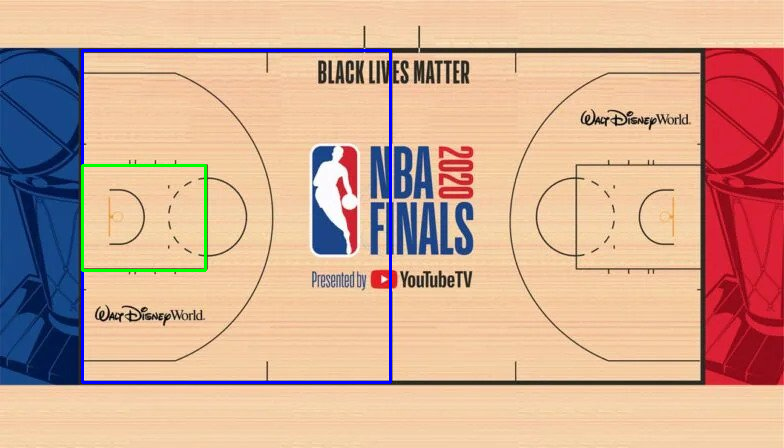

In [16]:
img_dst = cv2.imread('2d.jpg')

dst_rightpts = np.array([
      [398,  42],  # LEFT BOTTOM
      [398,  420],  # RIGHT BOTTOM
      [752,  420],   # TOP RIGHT  (4 o'clock)
      [752, 42]     # TOP LEFT (7 o'clock)
    ])  

dst_leftpts= np.array([
      [390,  50],  # TR
      [390,  382],  # BR
      [82,382],   # BL  (4 o'clock)
      [82,50]# TL (7 o'clock)
    ]) 

dst_midpts = np.array([
      [265,  43] ,  # LEFT BOTTOM
      [265,  420],  # RIGHT BOTTOM
      [534,  420],   # TOP RIGHT  (4 o'clock)
      [534, 43]  # TOP LEFT (7 o'clock)
    ])

dst_paint = np.array([
      [205,  165],  # TR
      [205 ,  270],  # BR
      [82,270],   # BL  (4 o'clock)
      [82,165]# TL (7 o'clock)
    ])




cv2.polylines(img_dst, [dst_leftpts], isClosed=True, color=[255,0,0], thickness=2)
cv2.polylines(img_dst, [dst_paint], isClosed=True, color=[0,255,0], thickness=2)
cv2_imshow(img_dst)

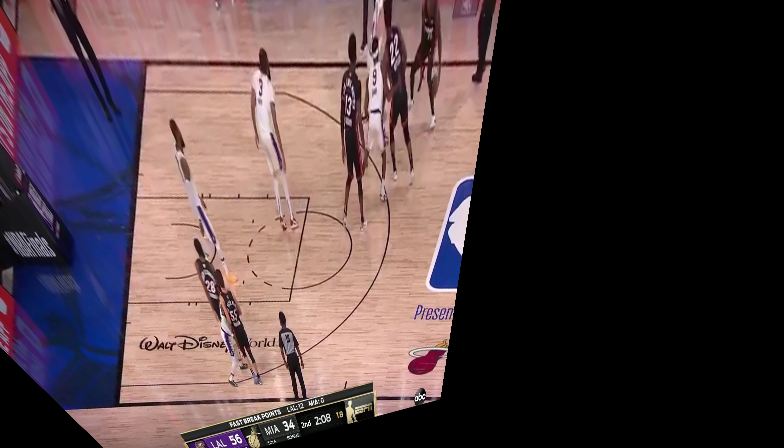

In [19]:
def homographyLeftTransform(im,showResult=False):
    # Calculate Homography
    h, status = cv2.findHomography(src_leftpts, dst_leftpts)
    img_out = cv2.warpPerspective(im, h, (img_dst.shape[1], img_dst.shape[0]))
  
    if showResult:
        cv2_imshow(img_out)
    return h
# Try out
img_out = homographyLeftTransform(im, True)

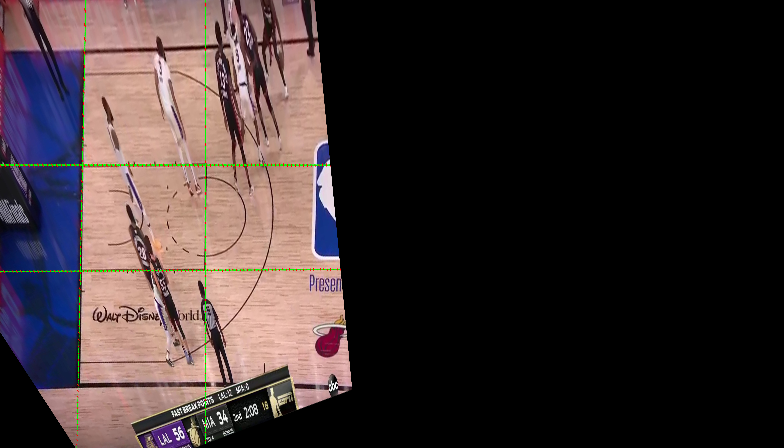

In [17]:
def homographyPaintTransform(im,showResult=False):
    # Calculate Homography
    h, status = cv2.findHomography(src_paint, dst_paint)
    img_out = cv2.warpPerspective(im, h, (img_dst.shape[1], img_dst.shape[0]))
  
    if showResult:
        cv2_imshow(img_out)
    return h
# Try out
img_out = homographyPaintTransform(im, True)

# **3D => 2D**

In [18]:
def apply_homography(H,pts):
    """
    Apply a specified homography H to a set of 2D point coordinates

    Parameters
    ----------
    H : 3x3 array
        matrix describing the transformation

    pts : 2xN array
        2D coordinates of points to transform

    Returns
    -------
    numpy.array (dtype=float)
        2xN array containing the transformed points

    """

    #assert expected dimensions of input
    assert(H.shape==(3,3))
    assert(pts.shape[0]==2)
    assert(pts.shape[1]>=1)

    tpts = np.zeros(pts.shape)
    for i in range(pts.shape[1]):
        u = H[0][0]*pts[0][i] + H[0][1]*pts[1][i] + H[0][2]
        v = H[1][0]*pts[0][i] + H[1][1]*pts[1][i] + H[1][2]
        w = H[2][0]*pts[0][i] + H[2][1]*pts[1][i] + H[2][2]

        x_prime = u/w
        y_prime = v/w

        tpts[0][i] = x_prime
        tpts[1][i] = y_prime
    
    #make sure transformed pts are correct dimension
    assert(tpts.shape[0]==2)
    assert(tpts.shape[1]==pts.shape[1])

    return tpts


def create_images(im,box_coords):
    dir = os.listdir('./imgs') 
    if len(dir) != 0:
        shutil.rmtree('./imgs')
        #print('Successful Removal')
        os.mkdir('./imgs')
        #print('Successful Creation')
        image = im
        copy = image.copy()

        ROI_number = 0
        for k,v in box_coords.items():
            x,y,w,h = int(v[0]),int(v[1]),int(v[2]),int(v[3])
            ROI = image[y:h, x:w]
            cv2.imwrite(os.path.join('./imgs','ROI_{}.png'.format(k)), ROI)
            cv2.rectangle(copy,(x,y),(w,h),(36,255,12),2)
        #print('Directory Newly Populated')
        
    else:  
        image = im
        copy = image.copy()

        ROI_number = 0
        for k,v in box_coords.items():
            x,y,w,h = int(v[0]),int(v[1]),int(v[2]),int(v[3])
            ROI = image[y:h, x:w]
            cv2.imwrite(os.path.join('./imgs','ROI_{}.png'.format(k)), ROI)
            cv2.rectangle(copy,(x,y),(w,h),(36,255,12),2)
        #print('Directory Populated')
        #cv2_imshow(copy)

def drawPlayers(im, pred_boxes, h, src, circles=False, print=False):
    court_2D = cv2.imread('2d.jpg')
    color = [255, 0, 0]   
    thickness = 8
    radius = 8
    temp = []
    new_pts = []
    player_coord_init = {}
    i = 0
    dst_leftpts= np.array([
      [390,  50],  # TR
      [390,  382],  # BR
      [82,382],   # BL  (4 o'clock)
      [82,50]# TL (7 o'clock)
    ]) 
    for box in pred_boxes:
        if pred_classes[i] == 0 or 32: 
            x1 = int(box[0])
            y1 = int(box[1])
            x2 = int(box[2])
            y2 = int(box[3])
            #print(box[0])
            xc = x1 + int((x2 - x1)/2)
            player_pos1 = (xc - 1, y2)
            player_pos2 = (xc + 1, y2 + 1)
            
        player_posx = np.array([xc])
        player_posy = np.array([y2])
        player_pos = np.array([player_posx,player_posy])
        new_player_pos = apply_homography(h,player_pos)
        court = Polygon(dst_leftpts)
      # Draw only players that are within the basketball court
        if Point(new_player_pos).within(court):
            if circles:
                #player_posx = np.array([xc])
                #player_posy = np.array([y2])
                #player_pos = np.array([player_posx,player_posy])
                #new_player_pos = apply_homography(h,player_pos)
                # color = tuple([randint(0,256),randint(0,256),randint(0,256)]) # random color
                color = tuple([0, 0, 255]) # just red
                center = (int(new_player_pos[0]), int(new_player_pos[1]))
                radius = 5
                cv2.circle(court_2D, center, radius, color, thickness=-1)
                if pred_classes[i] == 32:
                    print('Found Ball')
                    temp.append((pred_boxes[i],new_player_pos,'ball'))
                else:
                    temp.append((pred_boxes[i],new_player_pos))
                #playerpos_new = homographyTransform(im, False,temp[])
                i+=1
                #print("[% 3d, % 3d]" %(xc, y2))
            cv2.rectangle(im, player_pos1, player_pos2, color, thickness)
    #create_images(im,player_coord_init)

    
    
    for i in temp:
        for element in i[0]:
            element = element.tolist()
            x,y=i[1][0],i[1][1]
            index = ((int(x[0]),int(y[0])))
            try:
                full = str(index) + '-' + str(i[2])
                player_coord_init[full] = element
            except:
                player_coord_init[index] = element
    #print(player_coord_init)
    create_images(im,player_coord_init)
    if print:
        cv2_imshow(im)
        cv2_imshow(court_2D)
    return court_2D


#h = homographyPaintTransform(im, False)
#output = drawPlayers(im, pred_boxes, h, 'left',True)
#cv2_imshow(output)

# **Testing**

In [26]:
cap = cv2.VideoCapture('./videos/cs231a_vid.mov')
i=0
path = './outputs'
court_2D = cv2.imread('2d.jpg')
frame_h = int(court_2D.shape[1])
frame_w = int(court_2D.shape[0])
size = (frame_w, frame_h)
#result = cv2.VideoWriter('output.avi', 
#                         cv2.VideoWriter_fourcc(*'MJPG'),
#                         6, size)
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break

    players_output = predictor(frame)
    instances = players_output["instances"]
    pred_boxes = instances.get("pred_boxes")
    pred_classes = instances.get("pred_classes")

    h = homographyPaintTransform(frame, False)
    output = drawPlayers(frame, pred_boxes, h, 'left', True)

    cv2.imwrite(os.path.join(path , 'output'+str(i)+ '.jpg'), output)

    #result.write(frame)
    # print(i)
    i+=1
 
cap.release()
#result.release()
cv2.destroyAllWindows()

Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Successful Creation
Directory Newly Populated
Successful Removal
Succes

In [19]:
cap= cv2.VideoCapture('./videos/cs231a_vid.mov')
i=0
input_path = './frames'
output_path = './outputs'

for filename in os.listdir(input_path):
    file_path = os.path.join(input_path, filename)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
    except Exception as e:
        print(f"Error deleting {file_path}: {e}")

for filename in os.listdir(output_path):
    file_path = os.path.join(output_path, filename)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
    except Exception as e:
        print(f"Error deleting {file_path}: {e}")

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break

    cv2.imwrite(os.path.join(input_path , str(i)+ '.jpg'), frame)
    i+=1
 
cap.release()
cv2.destroyAllWindows()

def keyFunc(string):
  output = string[:len(string)-4]
  return int(output)

frames_list = os.listdir(input_path)
frames_list.sort(key = keyFunc)

corners = np.array([[1670,600], [1490,800], [695,700], [975,520]])
dst_paint = np.array([
      [205,  165],  # TR
      [205 ,  270],  # BR
      [82,270],   # BL  (4 o'clock)
      [82,165]# TL (7 o'clock)
    ])

for i in range(len(frames_list) - 1):
  print(i)
  filename1 = frames_list[i]
  filename2 = frames_list[i + 1]
  img1 = cv2.imread(os.path.join(input_path, filename1),cv2.IMREAD_COLOR)
  img2 = cv2.imread(os.path.join(input_path, filename2),cv2.IMREAD_COLOR)
  optical_points = np.empty((0, 2), dtype=np.int32)
  result = img1.copy()

  players_output = predictor(img1)
  instances = players_output["instances"]
  pred_boxes = instances.get("pred_boxes")
  pred_classes = instances.get("pred_classes")

  for cur in corners:
    center = (cur[0], cur[1])
    cv2.circle(img1, center, 5, (0, 255, 0), -1)

  h, status = cv2.findHomography(corners, dst_paint)
  if h is not None:
    output = drawPlayers(img1, pred_boxes, h, 'left', True)
    cv2.imwrite(os.path.join(output_path , 'output'+str(i)+ '.jpg'), output)

  optical_points = np.append(optical_points, find_line(img1, corners[0], corners[1]), axis=0)
  optical_points = np.append(optical_points, find_line(img1, corners[0], corners[3]), axis=0)
  optical_points = np.append(optical_points, find_line(img1, corners[2], corners[3]), axis=0)
  optical_points = np.append(optical_points, find_line(img1, corners[1], corners[2]), axis=0)

  optical_points = filterPoints(optical_points, img1) # filter for out of bounds
  new_points = findOpticalFlow(img1, img2, optical_points)

  inframe_h = find_homography_ransac(optical_points, new_points)
  new_corners = apply_homography(inframe_h, corners.T).T
  corners = new_corners.astype(int)






0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163


# **Build Video**

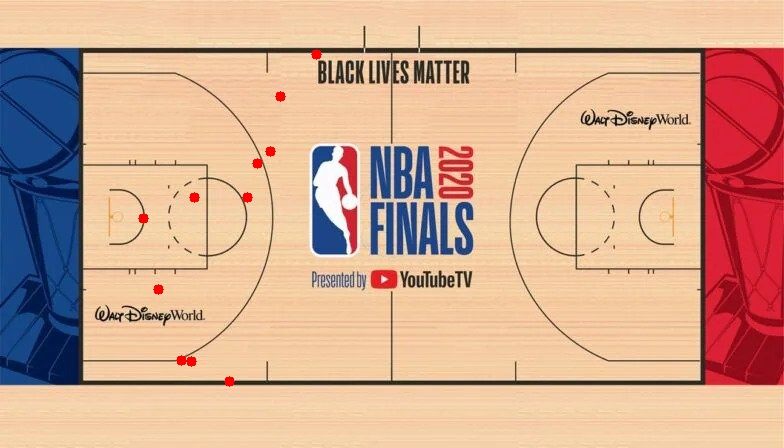

In [17]:
fps = 10
im = cv2.imread('./outputs/output0.jpg')
cv2_imshow(im)
frame_size = (im.shape[1], im.shape[0])

# Path to the input frames
input_frames_dir = './outputs'

# Path to the output video file
output_video_path = './videos/video.mp4'

# Get the list of frame files
frame_files = sorted(os.listdir(input_frames_dir))

# Create a video writer object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

# Loop through the frames and add them to the video
for frame_file in frame_files:
    # Load the image frame
    frame_path = os.path.join(input_frames_dir, frame_file)
    frame = cv2.imread(frame_path)

    # Resize the frame if necessary
    if frame.shape[:2] != frame_size:
        frame = cv2.resize(frame, frame_size)

    # Add the frame to the video
    out.write(frame)

# Release the video writer
out.release()